In [1]:
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


class DatasetGenerator(object):
    def __init__(self, data_dir, input_size, output_size, batch_size):
        self.data_dir = Path(data_dir)
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self._num_bbox = 0

    def run(self, train_num_bbox, val_num_bbox, preprocessed=None):
        return self.get_tfdataset(
            train=True, num_bbox=train_num_bbox,
            preprocessed=preprocessed), self.get_tfdataset(
                train=False, num_bbox=val_num_bbox)

    def get_tfdataset(self, train, num_bbox, preprocessed=None):
        self._num_bbox = num_bbox
        tfrecords_dir = self.data_dir / 'tfrecords' / f'{"train" if train else "val"}_{self.input_size}'
        tfrecords_files = [str(f) for f in tfrecords_dir.glob('*.tfrecords')]
        tfrecords = tf.data.TFRecordDataset(
            tfrecords_files, num_parallel_reads=len(tfrecords_files)) # reading tfrecord file
        ds = tfrecords
        if train:
            ds = ds.shuffle(buffer_size=10000, seed=42) 
        ds = ds.map(self._parse_tfrecord,
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if train and preprocessed:
            ds = ds.map(self._convert_image_float32,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
            for preprocess in preprocessed:
                ds = ds.map(preprocess,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
            ds = ds.map(self._convert_image_uint8,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(lambda i, o: (preprocess_input(tf.cast(i, tf.float32)), o),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)    

        return ds

    def _parse_tfrecord(self, tfrecord):
        tf_example = tf.io.parse_single_example(tfrecord,
                                                features={
                                                    'image_raw':
                                                    tf.io.FixedLenFeature(
                                                        (), tf.string),
                                                    'bboxes':
                                                    tf.io.FixedLenFeature(
                                                        (self._num_bbox, 4),
                                                        tf.float32)
                                                }) #feature parsing
        image = tf.image.decode_jpeg(tf_example['image_raw'], channels=3)
        bboxes = tf_example['bboxes']
        
        return image, bboxes

    def _convert_image_float32(self, image, bboxes):
        return tf.image.convert_image_dtype(image, tf.float32), bboxes

    def _convert_image_uint8(self, image, bboxes):
        return tf.image.convert_image_dtype(image, tf.uint8), bboxes


In [2]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import tensorflow as tf

def draw_bbox(image, bboxes):
    plt.imshow(image)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        patch = patches.Rectangle((float(x1), float(y1)), float(x2-x1), float(y2-y1), alpha=0.5)
        plt.gca().add_patch(patch)
    plt.show()
    plt.clf()

In [3]:
def random_factor(minval=0, maxval=None):
    return tf.random.uniform([], minval, maxval, seed=42)

def get_factor(image):
    input_size = tf.cast(tf.shape(image)[0], tf.float32)
    last_coord = input_size - 1
    return last_coord


def random_resize(image, bboxes):
    last_coord = get_factor(image)
    random_diff = random_factor(-0.3 * last_coord, 0.3 * last_coord)
    random_diff_ratio = random_diff / last_coord
    do_a_resize_random = random_factor()

    adjusted_image = tf.cond(
        do_a_resize_random < 0.3,
        true_fn=lambda: image_resize(image,random_diff_ratio),
        false_fn=lambda: image)

    adjusted_bboxes = tf.cond(
        do_a_resize_random < 0.3,
        true_fn=lambda: bbox_resize(last_coord, bboxes, random_diff),
        false_fn=lambda: bboxes)

    return adjusted_image, adjusted_bboxes


def image_resize(image,random_diff_ratio):
    input_size = tf.cast(tf.shape(image)[0], tf.float32)
    resized_image = tf.image.crop_and_resize([image],
                                             [[random_diff_ratio, random_diff_ratio, 1 - random_diff_ratio,
                                               1 - random_diff_ratio]],
                                             [0], [int(input_size), int(input_size)])[0]

    return resized_image


def bbox_resize(last_coord, bboxes, random_diff):
    valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
    resized_bboxes = (valid_bboxes - random_diff) * last_coord / (last_coord - 2 * random_diff)

    if random_diff > 0: resized_bboxes = crop_bbox(last_coord, resized_bboxes)

    resized_bboxes = tf.pad(resized_bboxes, [[0, tf.shape(bboxes)[0] - tf.shape(resized_bboxes)[0]], [0, 0]],
                            'CONSTANT')

    return resized_bboxes


def crop_bbox(last_coord, bboxes):

    valid_bboxes = bboxes[tf.reduce_all(tf.logical_and(
        tf.logical_and((bboxes[:, 0:1] < last_coord), (bboxes[:, 2:3] > 0)),
        tf.logical_and((bboxes[:, 1:2] < last_coord), (bboxes[:, -1:] > 0))),
                                          axis=-1)]

    xmin, ymin, xmax, ymax = tf.split(value=valid_bboxes,
                                      num_or_size_splits=4,
                                      axis=1)

    xmin = tf.where(xmin < 0, 0., xmin)
    ymin = tf.where(ymin < 0, 0., ymin)
    xmax = tf.where(xmax > last_coord, last_coord, xmax)
    ymax = tf.where(ymax > last_coord, last_coord, ymax)

    cropped_bboxes = tf.concat([xmin, ymin, xmax, ymax], 1)

    return cropped_bboxes

def random_flip_lr(image, bboxes):
    do_a_flip_random = random_factor()
    last_coord = get_factor(image)
    
    adjusted_image = tf.cond(
        do_a_flip_random < 0.3,
        true_fn=lambda: image_flip_lr(image),
        false_fn=lambda: image)

    adjusted_bboxes = tf.cond(
        do_a_flip_random < 0.3,
        true_fn=lambda: bbox_flip_lr(last_coord, bboxes),
        false_fn=lambda: bboxes)

    return adjusted_image, adjusted_bboxes


def image_flip_lr(image):
    return tf.image.flip_left_right(image)


def bbox_flip_lr(last_coord, bboxes):
    valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
    flipped_bboxes = tf.gather(valid_bboxes, [2, 1, 0, 3], axis=-1) * [-1., 1., -1., 1.] + [last_coord, 0., last_coord, 0.]
    flipped_bboxes = tf.pad(flipped_bboxes, [[0, tf.shape(bboxes)[0] - tf.shape(flipped_bboxes)[0]], [0, 0]],'CONSTANT')

    return flipped_bboxes

In [4]:
data_dir = 'data'
input_size = 512
output_size = input_size/4
batch_size = 6

## original image and bounding box

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


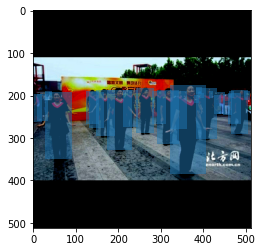

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


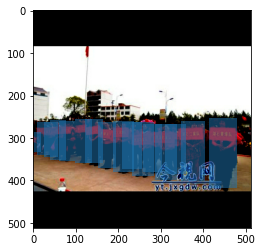

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


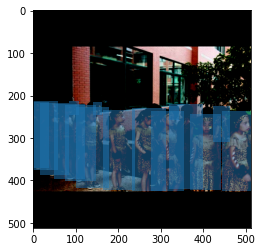

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


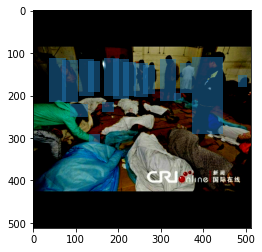

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


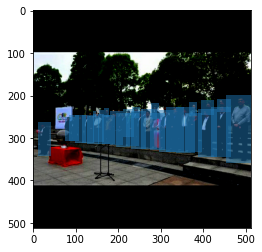

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


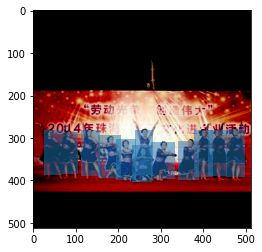

<Figure size 432x288 with 0 Axes>

In [5]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        draw_bbox(image, valid_bboxes)

## random resized image & bounding box

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


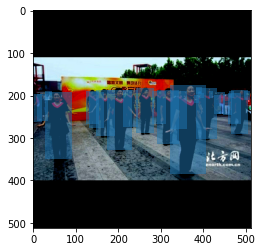

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


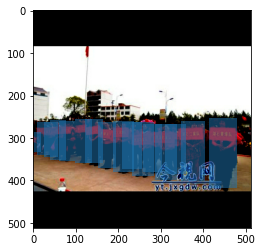

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


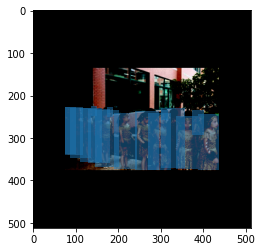

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


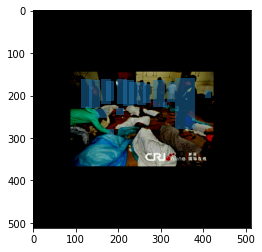

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


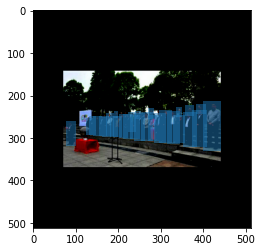

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


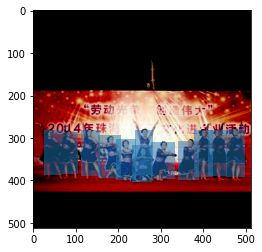

<Figure size 432x288 with 0 Axes>

In [6]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [random_resize])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]    
        draw_bbox(image, valid_bboxes)

## random flipped image & bounding box

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


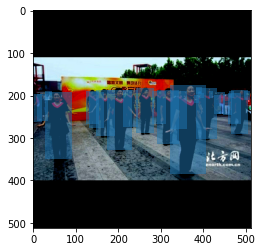

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


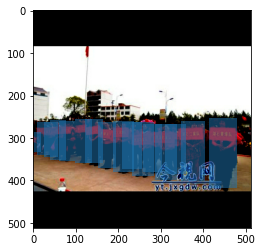

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


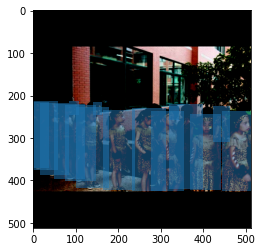

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


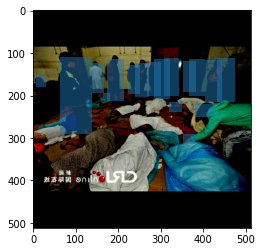

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


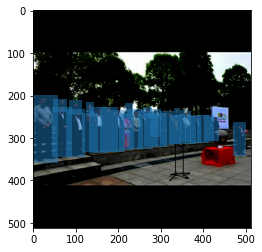

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


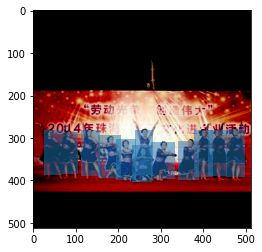

<Figure size 432x288 with 0 Axes>

In [7]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [random_flip_lr])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        draw_bbox(image, valid_bboxes)

# Check function

In [8]:
data_dir = 'data'
input_size = 512
output_size = input_size/4
batch_size = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


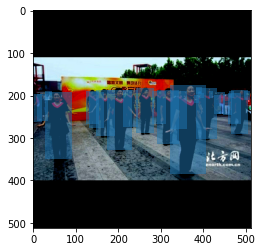

tf.Tensor(
[[  0.       196.21036   20.474123 261.89816 ]
 [  9.383973 197.06345   34.976627 260.192   ]
 [ 28.15192  191.09181   92.13355  348.91318 ]
 [123.69783  188.53255  155.2621   267.86978 ]
 [131.37563  192.798    165.49916  277.25375 ]
 [147.5843   187.67946  191.94492  295.1686  ]
 [174.03004  185.97328  232.04007  328.43906 ]
 [211.56595  187.67946  245.68948  273.8414  ]
 [242.27713  183.41402  284.07846  287.4908  ]
 [280.6661   189.38564  313.08347  267.86978 ]
 [291.75626  187.67946  343.79465  313.93655 ]
 [324.1736   188.53255  361.7095   279.81302 ]
 [321.61435  175.73622  406.92322  384.74292 ]
 [383.0367   183.41402  431.66278  302.8464  ]
 [431.66278  191.94492  452.1369   243.13022 ]
 [447.01837  195.35727  467.4925   244.8364  ]
 [458.9616   193.6511   488.8197   267.0167  ]
 [464.93323  187.67946  506.73456  291.75626 ]
 [424.83807  197.91653  442.75293  243.13022 ]
 [ 26.445744 188.53255   45.213688 209.00668 ]
 [383.0367   179.14857  397.53925  195.35727 ]
 [

<Figure size 432x288 with 0 Axes>

In [9]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

In [10]:
def resize_crop(image, bboxes):

    last_coord = get_factor(image)
    random_diff = 0.3 * last_coord
    random_diff_ratio = random_diff / last_coord

    adjusted_image = image_resize(image, random_diff_ratio)
    adjusted_bboxes = bbox_resize(last_coord, bboxes, random_diff)

    return adjusted_image, adjusted_bboxes

def resize_pad(image, bboxes):

    last_coord = get_factor(image)
    random_diff = -0.3 * last_coord
    random_diff_ratio = random_diff / last_coord

    adjusted_image = image_resize(image, random_diff_ratio)
    adjusted_bboxes = bbox_resize(last_coord, bboxes, random_diff)

    return adjusted_image, adjusted_bboxes

def flip_lr(image, bboxes):
    
    last_coord = get_factor(image)
    adjusted_image = image_flip_lr(image)
    adjusted_bboxes = bbox_flip_lr(last_coord, bboxes)

    return adjusted_image, adjusted_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


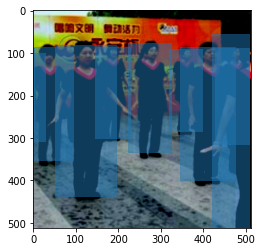

tf.Tensor(
[[  0.        88.08136    4.905243 286.42444 ]
 [  0.        98.745     30.497894 309.8844  ]
 [  0.        85.94865   96.61229  354.67154 ]
 [ 51.825104  81.6832   196.85017  437.84763 ]
 [145.66487   85.94865  230.97371  301.3535  ]
 [222.44283   75.285034 326.94614  335.47705 ]
 [318.41525   90.21408  399.45868  286.42444 ]
 [346.14066   85.94865  476.23663  401.5914  ]
 [427.18402   88.08136  511.       316.28256 ]
 [420.7859    56.090546 511.       511.      ]], shape=(10, 4), dtype=float32)


<Figure size 432x288 with 0 Axes>

In [11]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [resize_crop])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


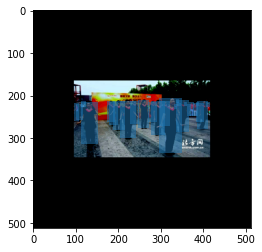

tf.Tensor(
[[ 95.81251  218.44398  108.60883  259.49887 ]
 [101.67748  218.97717  117.6729   258.43253 ]
 [113.407455 215.24489  153.39598  313.88324 ]
 [173.12364  213.64536  192.85132  263.23114 ]
 [177.92227  216.31128  199.24948  269.09613 ]
 [188.05269  213.11217  215.77809  280.2929  ]
 [204.58128  212.04582  240.83755  301.08694 ]
 [228.04124  213.11217  249.36845  266.9634  ]
 [247.23572  210.44626  273.36157  275.49426 ]
 [271.22882  214.17853  291.4897   263.23114 ]
 [278.1602   213.11217  310.68417  292.02286 ]
 [298.42102  213.64536  321.88098  270.69565 ]
 [296.82147  205.64766  350.13953  336.27686 ]
 [335.21045  210.44626  365.60175  285.09152 ]
 [365.60175  215.77809  378.39807  247.76889 ]
 [375.199    217.91081  387.99533  248.83527 ]
 [382.6635   216.84445  401.3248   262.69797 ]
 [386.39578  213.11217  412.5216   278.1602  ]
 [361.3363   219.51035  372.53308  247.76889 ]
 [112.341095 213.64536  124.07105  226.44168 ]
 [335.21045  207.78036  344.27454  217.91081 ]
 [

<Figure size 432x288 with 0 Axes>

In [12]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [resize_pad])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


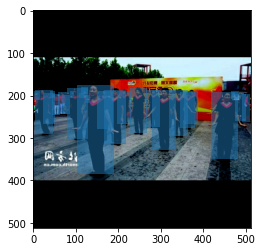

tf.Tensor(
[[490.52588  196.21036  511.       261.89816 ]
 [476.02338  197.06345  501.61603  260.192   ]
 [418.86646  191.09181  482.84808  348.91318 ]
 [355.7379   188.53255  387.3022   267.86978 ]
 [345.50085  192.798    379.6244   277.25375 ]
 [319.05508  187.67946  363.4157   295.1686  ]
 [278.95993  185.97328  336.96997  328.43906 ]
 [265.31052  187.67946  299.43405  273.8414  ]
 [226.92154  183.41402  268.72287  287.4908  ]
 [197.91653  189.38564  230.3339   267.86978 ]
 [167.20535  187.67946  219.24374  313.93655 ]
 [149.2905   188.53255  186.82639  279.81302 ]
 [104.07678  175.73622  189.38565  384.74292 ]
 [ 79.33722  183.41402  127.96329  302.8464  ]
 [ 58.8631   191.94492   79.33722  243.13022 ]
 [ 43.507507 195.35727   63.98163  244.8364  ]
 [ 22.180298 193.6511    52.03839  267.0167  ]
 [  4.265442 187.67946   46.066772 291.75626 ]
 [ 68.24707  197.91653   86.16193  243.13022 ]
 [465.78632  188.53255  484.55426  209.00668 ]
 [113.460754 179.14857  127.96329  195.35727 ]
 [

<Figure size 432x288 with 0 Axes>

In [13]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [flip_lr])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

## test crop_bbox code

In [14]:
def bbox_resize(last_coord, bboxes, random_diff):

    valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
    resized_bboxes = (valid_bboxes - random_diff) * last_coord / (last_coord - 2 * random_diff)

#     if random_diff > 0: resized_bboxes = crop_bbox(last_coord, resized_bboxes)

    resized_bboxes = tf.pad(resized_bboxes, [[0, tf.shape(bboxes)[0] - tf.shape(resized_bboxes)[0]], [0, 0]],
                            'CONSTANT')

    return resized_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


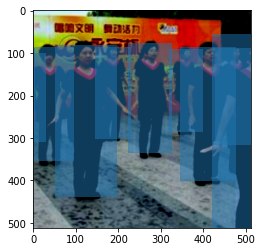

tf.Tensor(
[[-383.25003   107.275894 -332.0647    271.49542 ]
 [-359.7901    109.40861  -295.80844   267.22998 ]
 [-312.8702     94.47953  -152.91614   489.03296 ]
 [ -74.00543    88.08136     4.905243  286.42444 ]
 [ -54.810944   98.745      30.497894  309.8844  ]
 [ -14.289246   85.94865    96.61229   354.67154 ]
 [  51.825104   81.6832    196.85017   437.84763 ]
 [ 145.66487    85.94865   230.97371   301.3535  ]
 [ 222.44283    75.285034  326.94614   335.47705 ]
 [ 318.41525    90.21408   399.45868   286.42444 ]
 [ 346.14066    85.94865   476.23663   401.5914  ]
 [ 427.18402    88.08136   521.0238    316.28256 ]
 [ 420.7859     56.090546  634.05804   578.6073  ]
 [ 574.3418     75.285034  695.90704   373.86603 ]
 [ 695.90704    96.61229   747.0923    224.57553 ]
 [ 734.29596   105.14317   785.4813    228.84099 ]
 [ 764.1541    100.87772   838.7993    284.29175 ]
 [ 779.08307    85.94865   883.5864    346.14066 ]
 [ 678.8453    111.54133   723.6324    224.57553 ]
 [-317.13565    88.0

<Figure size 432x288 with 0 Axes>

In [15]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [resize_crop])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

In [16]:
def bbox_resize(last_coord, bboxes, random_diff):

    valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
    resized_bboxes = (valid_bboxes - random_diff) * last_coord / (last_coord - 2 * random_diff)

    if random_diff > 0: resized_bboxes = crop_bbox(last_coord, resized_bboxes)

    resized_bboxes = tf.pad(resized_bboxes, [[0, tf.shape(bboxes)[0] - tf.shape(resized_bboxes)[0]], [0, 0]],
                            'CONSTANT')

    return resized_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


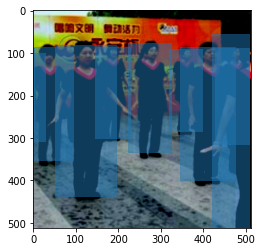

tf.Tensor(
[[  0.        88.08136    4.905243 286.42444 ]
 [  0.        98.745     30.497894 309.8844  ]
 [  0.        85.94865   96.61229  354.67154 ]
 [ 51.825104  81.6832   196.85017  437.84763 ]
 [145.66487   85.94865  230.97371  301.3535  ]
 [222.44283   75.285034 326.94614  335.47705 ]
 [318.41525   90.21408  399.45868  286.42444 ]
 [346.14066   85.94865  476.23663  401.5914  ]
 [427.18402   88.08136  511.       316.28256 ]
 [420.7859    56.090546 511.       511.      ]], shape=(10, 4), dtype=float32)


<Figure size 432x288 with 0 Axes>

In [17]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [resize_crop])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)